In [ ]:
from datasets import DatasetDict, Dataset, ClassLabel, Sequence, Value, Features
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from time import localtime, strftime, strptime
import os

In [ ]:
CL = 5
splits = ["train", "val", "test"]

def process(df):
    rows = []
    for _, conversation in df.groupby("Dialogue_ID"):
        for i in range(len(conversation) - 5 + 1):
            window = conversation[i:i + 5]
            rows.append([window["Utterance"].tolist(), window["Speaker"].tolist(), window["Emotion"].iloc[-1]])

    return pd.DataFrame(rows, columns=["text", "speaker", "labels"])

dfs = [pd.read_csv(f"../D0/{split}.csv") for split in ["train", "val", "test"]]
filtered_dfs = list(map(lambda df: df.groupby("Dialogue_ID").filter(lambda x: x["Utterance"].count() >= CL), dfs))
processed_dfs = map(process, filtered_dfs)

dataset_map = map(lambda df: Dataset.from_pandas(df, features=Features({
    "text": Sequence(Value(dtype="string"), length=5),
    "speaker": Sequence(Value(dtype="string"), length=5),
    "labels": ClassLabel(names=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]),
})), processed_dfs)

dataset = DatasetDict({s: df for s, df in zip(splits, dataset_map)})

aug_dfs = [pd.read_csv(f"../D2/{split}.csv") for split in ["train", "val", "test"]]
aug_filtered_dfs = list(map(lambda df: df.groupby("Dialogue_ID").filter(lambda x: x["Utterance"].count() >= CL), aug_dfs))
aug_processed_dfs = map(process, aug_filtered_dfs)

aug_dataset_map = map(lambda df: Dataset.from_pandas(df, features=Features({
    "text": Sequence(Value(dtype="string"), length=5),
    "speaker": Sequence(Value(dtype="string"), length=5),
    "labels": ClassLabel(names=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]),
})), aug_processed_dfs)

aug_dataset = DatasetDict({s: df for s, df in zip(splits, aug_dataset_map)})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    convs = [
        tokenizer.apply_chat_template(
            [{"role": "system", "content": f"How does {examples['speaker'][x][-1]} feel at the end of the conversation?"}] + \
            [{"role": examples["speaker"][x][i], "content": examples["text"][x][i] + " "} for i in range(CL)], 
            tokenize=False)
        for x in range(len(examples["text"]))
    ]

    encoding = tokenizer(convs, max_length=288, truncation=True)

    return encoding


def mask_all(examples):
    return {f"t{CL-1}": [tokenizer.mask_token for i in range(len(examples[f"t{CL-1}"]))]}

tokenized_dataset = dataset.map(preprocess_data, batched=True, batch_size=100000)
tokenized_aug_dataset = aug_dataset.map(preprocess_data, batched=True, batch_size=100000)

tokenized_masked_dataset = dataset.map(mask_all, batched=True, batch_size=100000).map(preprocess_data, batched=True, batch_size=100000)
tokenized_masked_aug_dataset = aug_dataset.map(mask_all, batched=True, batch_size=100000).map(preprocess_data, batched=True, batch_size=100000)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6221 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

In [44]:
CL = 5

f = {f"{k}{i}": Value(dtype="string") for k in "ts" for i in range(CL)}
dataset = load_dataset("csv", 
                       data_files={split: f"../D0/{split}.csv" for split in ["train", "val", "test"]},
                       features=Features({
                            **f,
                            "labels": ClassLabel(num_classes=8, names=["neutral", "joy", "sadness", "fear", "anger", "surprise", "disgust", "non-neutral"])
                       }))

aug_dataset = load_dataset("csv", 
                       data_files={split: f"../D2/{split}.csv" for split in ["train", "val", "test"]},
                       features=Features({
                            **f,
                            "labels": ClassLabel(num_classes=8, names=["neutral", "joy", "sadness", "fear", "anger", "surprise", "disgust", "non-neutral"])
                       }))

In [45]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    convs = [
        tokenizer.apply_chat_template(
            [{"role": "system", "content": f"How does {examples[f's{CL-1}'][x]} feel at the end of the conversation?"}] + \
            [{"role": examples[f"s{i}"][x], "content": examples[f"t{i}"][x] + " "} for i in range(CL)], 
            tokenize=False)
        for x in range(len(examples["labels"]))
    ]

    encoding = tokenizer(convs, max_length=512, truncation=True)

    return encoding

def mask_all(examples):
    return {f"t{CL-1}": [tokenizer.mask_token for i in range(len(examples[f"t{CL-1}"]))]}

tokenized_dataset = dataset.map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])

tokenized_aug_dataset = aug_dataset.map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])

tokenized_masked_dataset = dataset.map(mask_all, batched=True, batch_size=100000).map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])

tokenized_masked_aug_dataset = aug_dataset.map(mask_all, batched=True, batch_size=100000).map(preprocess_data, batched=True, batch_size=100000,
                                remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1964 [00:00<?, ? examples/s]

In [46]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
        "WA": accuracy_score(labels, predictions).tolist(),
        "UWA": balanced_accuracy_score(labels, predictions).tolist(),
        "miF1": f1_score(labels, predictions, average="micro"),
        "maF1": f1_score(labels, predictions, average="macro"),
        "wtF1": f1_score(labels, predictions, average="weighted"),
    }

    return metrics

In [47]:
loss_fn = nn.CrossEntropyLoss(torch.Tensor(1/np.bincount(dataset["train"]["labels"])).to("cuda"))
# loss_fn = nn.CrossEntropyLoss()

class MaskedTrainer(Trainer):
    rng = np.random.default_rng(42)
    endl_token = tokenizer.encode('\n')[1]
    mask_token = tokenizer.mask_token_id
    eos_token = tokenizer.eos_token_id
    pad_token = tokenizer.pad_token_id

    mask_ratio = 0.5

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)

        loss = loss_fn(outputs["logits"], labels)
        return (loss, outputs) if return_outputs else loss
    
    def training_step(self, model, inputs):
        mask_idx = self.rng.choice(len(inputs["input_ids"]), int(self.mask_ratio * len(inputs["input_ids"])), replace=False)
        for i in mask_idx:
            s = (inputs["input_ids"][i] == self.endl_token).nonzero()[-2].item()
            e = (inputs["input_ids"][i] == self.eos_token).nonzero()[-1].item()

            inputs["input_ids"][i][s+2:s+11] = inputs["input_ids"][i][e-8:e+1].clone()
            inputs["input_ids"][i][s+1] = self.mask_token
            inputs["input_ids"][i][s+11:e+1] = self.pad_token
            inputs["attention_mask"][i][s+11:e+1] = 0

        
        return super().training_step(model, inputs)

In [48]:
def get_checkpoint(epoch=0, run="latest", folder_path="results"):
    if run == "latest":
        run = max(os.listdir(folder_path), key=lambda x: strptime(x, "%b-%d-%y-%H:%M:%S"))

    checkpoint = sorted(os.listdir(f"{folder_path}/{run}"), key=lambda x: int(x.split("-")[1]))[epoch-1]

    return f"{folder_path}/{run}/{checkpoint}"

c = get_checkpoint(32)
model = AutoModelForSequenceClassification.from_pretrained(c)

In [49]:
training_args = TrainingArguments(
    output_dir="/tmp/tmp_trainer",
    per_device_eval_batch_size=64,
    report_to="none",
)

trainer = MaskedTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [50]:
trainer.evaluate(tokenized_dataset["test"])

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/31 [00:00<?, ?it/s]

{'eval_loss': 1.4886226654052734,
 'eval_WA': 0.4516293279022403,
 'eval_UWA': 0.5050396741833976,
 'eval_miF1': 0.4516293279022403,
 'eval_maF1': 0.3570450692405388,
 'eval_wtF1': 0.45239254615199065,
 'eval_runtime': 4.9696,
 'eval_samples_per_second': 395.201,
 'eval_steps_per_second': 6.238}

In [51]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/31 [00:00<?, ?it/s]

In [52]:
preds = pd.DataFrame(dataset["test"])
preds["pred"] = np.argmax(predictions[0], axis=1)

In [53]:
preds

,t0,t1,t2,t3,t4,s0,s1,s2,s3,s4,labels,pred
0,Why do all you're coffee mugs have numbers on ...,Oh. That's so Monica can keep track. That way ...,Y'know what?,It didn't.,"Okay, so what you used to have with Rachel, is...",Mark,Rachel,Rachel,Ross,Frank,1,0
1,Oh. That's so Monica can keep track. That way ...,Y'know what?,It didn't.,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?",Rachel,Rachel,Ross,Frank,Joey,5,5
2,Y'know what?,It didn't.,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?","It's so cool man, it's so, it's just 'cause be...",Rachel,Ross,Frank,Joey,Frank,1,1
3,It didn't.,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?","It's so cool man, it's so, it's just 'cause be...","Yeah, yeah.",Ross,Frank,Joey,Frank,Ross,0,0
4,"Okay, so what you used to have with Rachel, is...","Now, wh-what, what is that like?","It's so cool man, it's so, it's just 'cause be...","Yeah, yeah.",Why can't I find that?,Frank,Joey,Frank,Ross,Joey,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1959,"I don't know what it is, I just can't take a g...","Oh, here's a great one.","Yeah, I'm not in that.","I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",Chandler,Monica,Chandler,Monica,Phoebe,0,0
1960,"Oh, here's a great one.","Yeah, I'm not in that.","I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",That's a good idea! I bet they have one of tho...,Monica,Chandler,Monica,Phoebe,Monica,1,1
1961,"Yeah, I'm not in that.","I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",That's a good idea! I bet they have one of tho...,"Yeah that's great! Next to that, Chandler won'...",Chandler,Monica,Phoebe,Monica,Phoebe,0,1
1962,"I know, but look at me: all tan.","Hey, why don't you guys go get portraits done ...",That's a good idea! I bet they have one of tho...,"Yeah that's great! Next to that, Chandler won'...",Chandler what do you say?,Monica,Phoebe,Monica,Phoebe,Monica,0,0


In [54]:
for i in range(8):

    tp = (preds["labels"] == i) & (preds["pred"] == i)
    tn = (preds["labels"] != i) & (preds["pred"] != i)

    # print((sum(tp) + sum(tn))/len(preds))
    print(str(sum(tp) / sum(preds["labels"] == i)) + ", ")

0.4751131221719457, 
0.8267326732673267, 
0.676923076923077, 
0.5, 
0.5702479338842975, 
0.6794258373205742, 
0.2653061224489796, 
0.04656862745098039, 


In [55]:
sum([0.8415841584158416, 
0.6153846153846154, 
0.46153846153846156, 
0.5785123966942148, 
0.6650717703349283, 
0.2857142857142857, 
])/6

0.5746342813470579

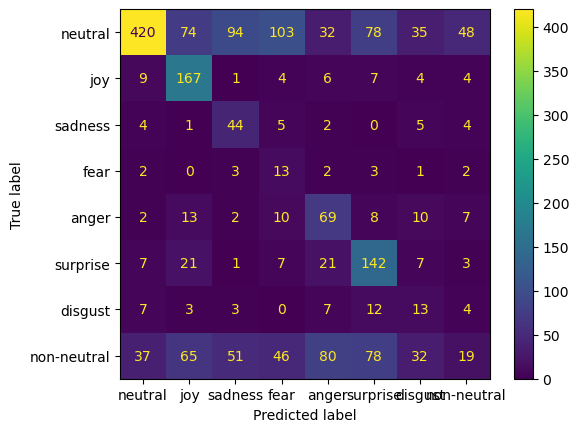

In [56]:
ConfusionMatrixDisplay.from_predictions(preds["labels"], preds["pred"], display_labels=dataset["train"].features["labels"].names)

In [63]:
from transformers import pipeline

model.to("cpu")
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

[{'label': 'LABEL_0', 'score': 0.14448025822639465}]

In [124]:
text_inputs = [
    [
        "My car just broke.", 
        "Mine's broken too. We can't go anywhere.", 
        "What about his?", 
        "Also broken. We're stuck.",
        "great",
    ], [
        "Let's go party", 
        "Sure!", 
        "Are you ready?", 
        "I'm all ready. Let's go!",
        "great",
    ],
]

role_names = ["Chandler", "Monica"]
convs = [
    tokenizer.apply_chat_template(
        [{"role": "system", "content": f"How does {role_names[0]} feel at the end of the conversation?"}] + \
        [{"role": role_names[i % 2], "content": x + " "} for i, x in enumerate(m)], 
        tokenize=False)
    for m in text_inputs
]

pipe(convs)

[{'label': 'LABEL_2', 'score': 0.5716767907142639},
 {'label': 'LABEL_1', 'score': 0.7224202156066895}]

[{'label': 'LABEL_2', 'score': 0.3754754364490509},
 {'label': 'LABEL_1', 'score': 0.7792950868606567},
 {'label': 'LABEL_2', 'score': 0.7461956143379211},
 {'label': 'LABEL_2', 'score': 0.4677414894104004}]

In [20]:
raise Exception

Exception: 

In [35]:
p = []

for i in range(31, 41):
    c = get_checkpoint(i)
    model = AutoModelForSequenceClassification.from_pretrained(c)

    training_args = TrainingArguments(
        output_dir="/tmp/tmp_trainer",
        per_device_eval_batch_size=64,
        report_to="none",
    )

    trainer = MaskedTrainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,

    )

    predictions = trainer.predict(tokenized_dataset["test"])

    scores = compute_metrics(predictions[:2])

    preds = pd.DataFrame(dataset["test"])
    preds["pred"] = np.argmax(predictions[0], axis=1)

    abc = []
    for i in range(8):
        tp = (preds["labels"] == i) & (preds["pred"] == i)
        tn = (preds["labels"] != i) & (preds["pred"] != i)

        # print((sum(tp) + sum(tn))/len(preds))
        abc.append(sum(tp) / sum(preds["labels"] == i))

    p.append(f"WA: {scores['WA']} UWA: {scores['UWA']} f: {sum(abc[1:7])/6}")

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [37]:
for x in p:
    print(x)

WA: 0.45824847250509165 UWA: 0.49684182075693933 f: 0.572932131044446
WA: 0.4516293279022403 UWA: 0.5050396741833976 f: 0.5864392739740425
WA: 0.4623217922606925 UWA: 0.5032976889532758 f: 0.5808172303187971
WA: 0.4714867617107943 UWA: 0.5009438865034904 f: 0.5728397119191838
WA: 0.47046843177189407 UWA: 0.4995620186638129 f: 0.5712171812450637
WA: 0.464867617107943 UWA: 0.4995054616641672 f: 0.5734042153511169
WA: 0.4694501018329939 UWA: 0.5024941008667072 f: 0.5764463828549561
WA: 0.46741344195519346 UWA: 0.49759601884905086 f: 0.569695647052631
WA: 0.4679226069246436 UWA: 0.4990479768474009 f: 0.5714744769227286
WA: 0.46741344195519346 UWA: 0.4990715439665562 f: 0.5714744769227286
